In [1]:
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np

from qutip import *
from scipy.interpolate import interp1d

from scipy.stats import kstest
from joblib import Parallel, delayed
from scipy.integrate import quad
from scipy.special import factorial, eval_hermite, comb
from scipy.special import laguerre
import matplotlib as mpl

### Operators

In [2]:
N = 15 # Fock space dimension

idc = qeye(N) # identity on cavity Hilbert space
ida = qeye(2) # identity on qubit Hilbert space

a  = tensor(destroy(N), ida) # cavity annilitation operator
sm = tensor(idc, destroy(2)) # qubit annihilation operator

# qubit Pauli sigma operators
sx = tensor(idc, sigmax()) 
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

# projector onto qubit ground state
proj0 = tensor(idc, basis(2,0).proj())

# projector onto qubit excited state
proj1 = tensor(idc, basis(2,1).proj())

## Define unitaries

In [3]:
# Rotation around Bloch sphere x-axis by angle theta
def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

# Rotation around Bloch sphere y-axis by angle theta
def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

# Rotation around Bloch sphere x- and y-axes. 
# Used for projecting z onto Bloch sphere equator plane and choosing quadrature
def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

# interaction unitary with effective strength g_int
def U_swap(theta):
    Hint = (-1j) * theta* (a.dag() * sm + a * sm.dag())
    return Hint.expm()

## Parameters 

In [4]:
# number of trajectories
Ntrajs = 1000

# set interaction strength
theta = 0.1*np.pi/2 # 0.1 SWAP

U_int = U_swap(theta)

### Homodyne settings

In [5]:
# homodyne angles
nangles = 10 # number of angles
homodyne_angles = np.linspace(0,np.pi, nangles) # list of all angles

# histogram parameters
Nbins = 60 # number of histogram bins
k = 7  # bin edge limit
dx =  2*k/Nbins # bin width

### Generate tomography operators

In [6]:
### Define the harmonic oscillator wavefunction
#To create homodyne POVM operators.

def wavefunction(x,n):
    const = 1/(np.sqrt(2**n * factorial(n)) * (np.pi)**0.25 )
    rest = const* np.exp(-x**2/2)
    return float(rest*eval_hermite(n,x))

### Construct operators

def get_Pis(theta, i):
    Pi = np.zeros((N,N),dtype=np.complex128)
    for m in range(N):
        wave_m = lambda x : wavefunction(x, m)
        for n in range(N):
            wave_n = lambda x: wavefunction(x, n)            
            func = lambda x: wave_m(x)*wave_n(x)
            Pi[n,m] = quad(func, -k + i*dx, -k + (i+1)*dx)[0]*np.exp(-1j*(n-m)*theta)
            
    return Pi*2 #

Pis = Parallel(n_jobs=16, verbose=0, backend="multiprocessing")(delayed(get_Pis)(theta,i) for theta in homodyne_angles for i in range(Nbins))

#The list `basis_dms` contains all $\Omega_k$
# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

### Construct the matrix A in $A\vec\rho=\vec b$
#From `Pis` and `basis_dms`.

def func(index, a):
    return np.trace(Pis[index[0]] @ basis_dms[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=0, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

### Analytic Wigner functions
To calculate marginals.

In [7]:
def wigner_cat(x,p, photon_nr):
    # https://ntrs.nasa.gov/api/citations/19960024997/downloads/19960024997.pdf Eq. (2)
    # interference term is only correct for coherent states on the x (real) axis
    # alpha = (x + ip)/sqrt(2)
    alpha = np.sqrt(photon_nr)
    p0 = 0
    x0 = np.sqrt(2)*alpha
    
    func = (np.exp(-(x-x0)**2 - (p-p0)**2) + np.exp(-(x+x0)**2 - (p+p0)**2))
    interference_term = 2*np.exp(-x**2 - p**2)*np.cos(2*x0*p)
    # cat state normalization # c_+ = sqrt(2 + 2*exp(-2*|alpha|^2)) and |alpha|^2 = photon_nr
    return (func + interference_term)/(2+2*np.exp(-2*photon_nr))/np.pi

In [8]:
def wigner_fock(x,p, photon_nr):
    return np.exp(-x**2 -p**2) * (-1)**photon_nr * laguerre(photon_nr)(2*x**2 + 2*p**2)/np.pi

In [9]:
def wigner_coherent(x,p, photon_nr):
    # alpha = (x + ip)/sqrt(2)
    alpha = np.sqrt(photon_nr)
    p0 = 0
    x0 = np.sqrt(2)*alpha
    func = np.exp(-(x-x0)**2 - (p-p0)**2)/np.pi
    return func

### Qubitdyne homodyne simulation

In [10]:
def run_sim(Nmeas, initial_cavity, wigner_function):
    psi0 = tensor(initial_cavity, basis(2,0))
    photon_nr = expect(num(N), initial_cavity)

    def wigner_angular(p, x_angle, rotangl, photon_nr, wigner_function):
        return wigner_function(x_angle*np.cos(rotangl) - p*np.sin(rotangl), x_angle*np.sin(rotangl) + p*np.cos(rotangl), photon_nr)
    
    
    def wigner_marginal(x_theta, rotangl, photon_nr, wigner_function):
        return quad(wigner_angular, -10,10, args=(x_theta, rotangl, photon_nr, wigner_function))[0]
    
    # get measurement histogram for one homodyne angle
    def get_hist(rotangl, Nmeas):

        xlist=np.linspace(-k,k,500)
        diffx = np.diff(xlist)[0]
        wintegral = [wigner_marginal(x,rotangl, photon_nr, wigner_function) for x in xlist]
        cdf = np.cumsum(wintegral)*diffx
        cdf_func = interp1d(xlist, cdf, fill_value="extrapolate") # cumulativve probability distributiin
        
        nsteps = np.linspace(0,Nmeas-1,Nmeas)
        weights=(theta/np.sqrt(2))*np.exp(-nsteps*(theta**2/2))
    
        qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
        
        qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
        measurements = [] # initiate list to store measurement results
    
        vacuum_pops = []
        for j in range(Ntrajs): # do Ntrajs trajectories
            xrnd = np.random.rand(Nmeas)
        
            results = [] # store results for one trajectory
            psi = psi0
    
            # perform qubit measurements
            for i in range(Nmeas):
                psi = qbrotmat * (U_int * psi)
                prob = expect(proj0,psi) # expectation value of qubit ground state
    
                # random measurement results
                if prob > xrnd[i]:
                    # measured g
                    results.append(-1)
                    psi = (proj0 * psi).unit() # project qubit to ground state
                else:
                    results.append(1)
                    # measured e
                    psi = (proj1 * psi).unit()
                    # go back to g
                    psi = qbfeedback * psi
    
            # store weigthed measurement results
            measurements.append(np.sum(results*weights))
            vacuum_pops.append(psi.ptrace(0)[0,0].real)
        
        ### create histogram ###    
        hist, bins, _ = plt.hist(measurements,Nbins,[-k,k], density=True, alpha=0.5, edgecolor='k')
        plt.plot(xlist, wintegral)
        ks_stat = kstest(measurements, cdf_func)[0] # Kolmogorov-Smirnov statistic
        print(ks_stat)
        return hist, ks_stat, np.mean(vacuum_pops)

    result = Parallel(n_jobs=nangles, verbose=1, backend="loky")(delayed(get_hist)(rotangle, Nmeas) for rotangle in homodyne_angles)
    
    b_all = np.array(result, dtype=object)[:,0]
    
    ks_stat = np.mean(np.array(result, dtype=object)[:,1])
    
    vacuum_pop = np.mean(np.array(result, dtype=object)[:,2])

    # Tomography to get fidelity
    b = np.concatenate([array for array in b_all])
    
    # Define the unknown state as a $N\times N$ Hermitian matrix
    X = cp.Variable((N,N), hermitian=True)
    
    #Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.
    
    cost = cp.norm(A @ cp.vec(X) - b, 2) 
    
    #Set the trace constraint and positive-semidefinite constraint
    constraints = [cp.trace(X) == 1, X >> 0 ]
    
    #Set up and solve the problem!
    
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(verbose=False, solver='SCS')
    
    # Assign the optimized state X to a Qobj.
    reconstructed_rho = Qobj(X.value)
    
    f=fidelity(reconstructed_rho, initial_cavity)**2

    return f, ks_stat, vacuum_pop

In [11]:
# try different number of measurements
nmeas_list = [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]

### Cat state

In [12]:
%%time
f_list_cat = []
ks_list_cat = []
vac_list_cat = []

#initial_cavity = 

alpha = 2
cat_state = (coherent(N, alpha) + coherent(N,-alpha)).unit()

for Nmeas in nmeas_list:
    print(Nmeas)
    f, ks_stat, vac = run_sim(Nmeas, cat_state, wigner_cat)
    f_list_cat.append(f)
    ks_list_cat.append(ks_stat)
    vac_list_cat.append(vac)

10


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    7.2s remaining:   28.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    8.0s finished


20


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    9.3s remaining:   37.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   10.0s finished


40


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   16.6s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.9s finished


60


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   23.7s remaining:  1.6min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   24.9s finished


80


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   30.8s remaining:  2.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   32.4s finished


100


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   38.6s remaining:  2.6min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   40.7s finished


120


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   45.8s remaining:  3.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   48.4s finished


140


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   51.8s remaining:  3.5min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   54.9s finished


160


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  1.0min remaining:  4.0min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.0min finished


180


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  1.1min remaining:  4.5min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.2min finished


200


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  1.2min remaining:  4.9min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.3min finished


220


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  1.3min remaining:  5.4min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.4min finished


240


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  1.5min remaining:  5.9min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.6min finished


CPU times: user 18.5 s, sys: 22 s, total: 40.5 s
Wall time: 10min 30s


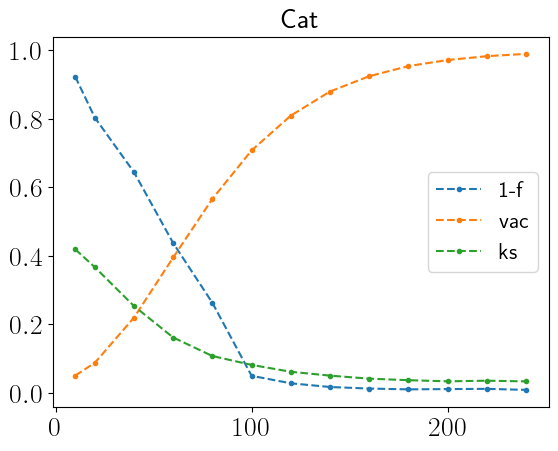

In [18]:
plt.plot(nmeas_list, 1-np.array(f_list_cat), '.--', label='1-f')
plt.plot(nmeas_list, vac_list_cat,'.--', label='vac')
plt.plot(nmeas_list, ks_list_cat, '.--',label='ks')
plt.title('Cat')
plt.legend();

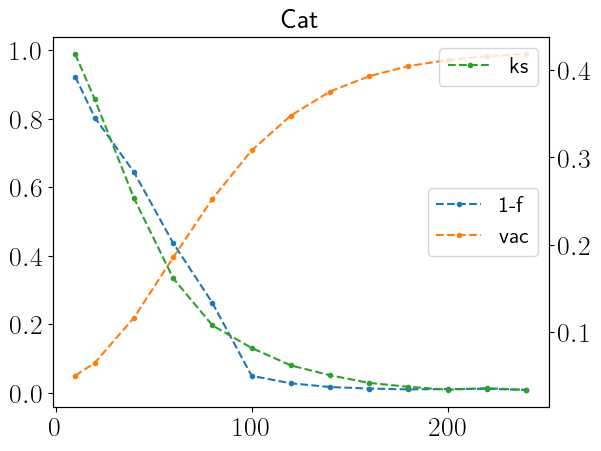

In [21]:
# plot KS on separate axis

fig, ax = plt.subplots()
ax.plot(nmeas_list, 1-np.array(f_list_cat), '.--', label='1-f')
ax.plot(nmeas_list, vac_list_cat,'.--', label='vac')
plt.legend();

ax2 = ax.twinx()
ax2.plot(nmeas_list, ks_list_cat, '.--',label='ks', color='C2')

plt.title('Cat')
plt.legend();

#### Fock

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   16.3s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   16.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   20.2s remaining:  1.3min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   20.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   26.9s remaining:  1.8min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   27.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   34.9s remaining:  2.3min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   35.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parall

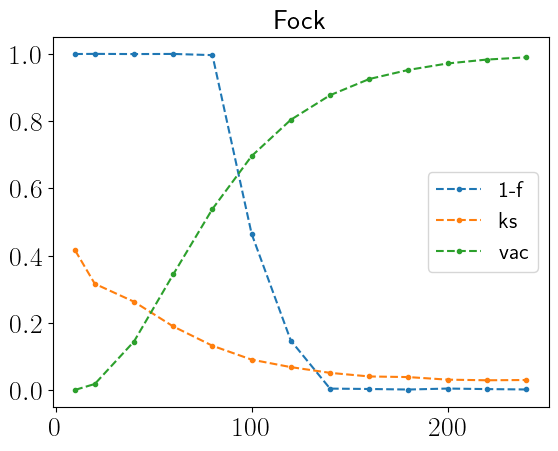

In [15]:
f_list = []
ks_list = []
vac_list = []

fock_state = fock(N,int(alpha**2))

for Nmeas in nmeas_list:
    f, ks_stat, vac = run_sim(Nmeas, fock_state, wigner_fock)
    f_list.append(f)
    ks_list.append(ks_stat)
    vac_list.append(vac)

plt.plot(nmeas_list, 1- np.array(f_list), '.--', label='1-f')
plt.plot(nmeas_list, ks_list, '.--',label='ks')
plt.plot(nmeas_list, vac_list,'.--', label='vac')
plt.title('Fock')
plt.legend();

#### Coherent

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    4.9s remaining:   19.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    5.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    8.4s remaining:   33.4s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    9.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   15.7s remaining:  1.0min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   22.4s remaining:  1.5min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   24.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parall

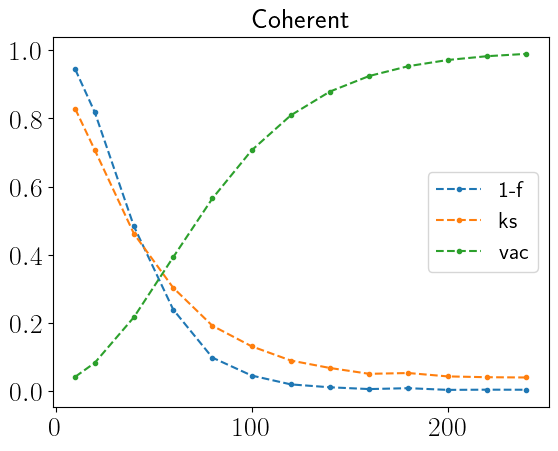

In [16]:
f_list_coh = []
ks_list_coh = []
vac_list_coh = []

coherent_state = coherent(N,alpha)

for Nmeas in nmeas_list:
    f, ks_stat, vac = run_sim(Nmeas, coherent_state, wigner_coherent)
    f_list_coh.append(f)
    ks_list_coh.append(ks_stat)
    vac_list_coh.append(vac)

plt.plot(nmeas_list, 1-np.array(f_list_coh), '.--', label='1-f')
plt.plot(nmeas_list, ks_list_coh, '.--',label='ks')
plt.plot(nmeas_list, vac_list_coh,'.--', label='vac')
plt.title('Coherent')
plt.legend();

## Check histogram

0.0450300051432108


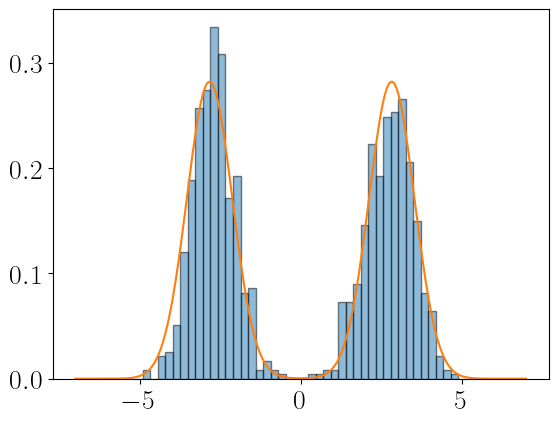

In [17]:
def run_sim_get_hist(rotangl, Nmeas, initial_cavity, wigner_function):
    psi0 = tensor(initial_cavity, basis(2,0))
    photon_nr = expect(num(N), initial_cavity)

    def wigner_angular(p, x_angle, rotangl, photon_nr, wigner_function):
        return wigner_function(x_angle*np.cos(rotangl) - p*np.sin(rotangl), x_angle*np.sin(rotangl) + p*np.cos(rotangl), photon_nr)
    
    
    def wigner_marginal(x_theta, rotangl, photon_nr, wigner_function):
        return quad(wigner_angular, -10,10, args=(x_theta, rotangl, photon_nr, wigner_function))[0]
    
    # get measurement histogram for one homodyne angle
    def get_hist(rotangl, Nmeas):

        xlist=np.linspace(-k,k,500)
        diffx = np.diff(xlist)[0]
        wintegral = [wigner_marginal(x,rotangl, photon_nr, wigner_function) for x in xlist]
        cdf = np.cumsum(wintegral)*diffx
        cdf_func = interp1d(xlist, cdf, fill_value="extrapolate")
        
        nsteps = np.linspace(0,Nmeas-1,Nmeas)
        weights=(theta/np.sqrt(2))*np.exp(-nsteps*(theta**2/2))
    
        qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
        
        qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
        measurements = [] # initiate list to store measurement results
    
        vacuum_pops = []
        for j in range(Ntrajs): # do Ntrajs trajectories
            xrnd = np.random.rand(Nmeas)
        
            results = [] # store results for one trajectory
            psi = psi0
    
            # perform qubit measurements
            for i in range(Nmeas):
                psi = qbrotmat * (U_int * psi)
                prob = expect(proj0,psi) # expectation value of qubit ground state
    
                # random measurement results
                if prob > xrnd[i]:
                    # measured g
                    results.append(-1)
                    psi = (proj0 * psi).unit() # project qubit to ground state
                else:
                    results.append(1)
                    # measured e
                    psi = (proj1 * psi).unit()
                    # go back to g
                    psi = qbfeedback * psi
    
            # store weigthed measurement results
            measurements.append(np.sum(results*weights))
            vacuum_pops.append(psi.ptrace(0)[0,0].real)
        
        ### create histogram ###    
        hist, bins, _ = plt.hist(measurements,Nbins,[-k,k], density=True, alpha=0.5, edgecolor='k')
        plt.plot(xlist, wintegral)
        ks_stat = kstest(measurements, cdf_func)[0]
        print(ks_stat)
        return hist, ks_stat, np.mean(vacuum_pops)
    get_hist(rotangl, Nmeas)


angle = 0
Nmeas = 200
# check cat
run_sim_get_hist(angle, Nmeas, cat_state, wigner_cat)